# Assignment #3

Cognitive modelling:Basic Principles and Methods

Sara Iglesias Suárez-Noguerol


## Simulated experiment

Structure of the experiment

- ITI randomly sampled between 500ms and 800ms.
- Foreperiod after warning stimulous S1: randomly chosen to be either 300,600, or 900ms.
- After foreperiod, the target stimulous S shows to the right or left.
- Response time: time between S2 and the key press.
- After, a feedback screen that lasts 350ms.

Block variables
- visibility: False: low, True:high
- reward: False: no reward, True: reward

In [1]:
from model import Model
from model_motivation import ModelWithMotivation
from dmchunk import Chunk
from time_funcs import time_to_pulses, pulses_to_time, noise
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
def distraction_time():
        distraction_mean_time = 0.0125 # average distraction time
        distraction_variation = 0.001 # variation in distraction (uniform)

        return random.uniform(distraction_mean_time - distraction_variation,
                          distraction_mean_time + distraction_variation)

def reaction_time(FP, pulses_av, max_RT, reward):

    attend_time = 0.050 # Default ACT-R time to fire a production
    exp_time = pulses_to_time(pulses_av)

    diff = (FP - exp_time)
    ## The response time is calculated
    if diff < 0:
            r_time = max_RT 
    elif diff > attend_time: 
            r_time = max_RT -  attend_time 
    else:
        r_time = max_RT - diff

    if not reward:
        r_time += distraction_time() #add a distraction time when the block is not rewarded
        
    return r_time


In [3]:

def run_trial(m, FP, trial, block, max_RT, reward):
        
        start_time = m.time # remember start time to make sure the timing is right.

        if m.time - start_time < FP and not m.distraction():
                # The target stimulous is not there and we are not distracted, so we prepare
                query = Chunk(name = "query", slots = {"isa": 'fp'})
                chunk, latency = m.retrieve(query)      # retrieve the chunck with highest activation

                m.time += latency + 0.05 # the production rule

                if chunk == None:
                        # in the first trial (or if no chunk is retreived) the response time is the maximum
                        rea_time = max_RT
                else:
                        pulses = chunk.slots["pulses"]
                        rea_time = reaction_time(FP, pulses, max_RT, reward)
                
                m.time = start_time + FP #+ response_time
            
        elif m.time - start_time < FP:
                rea_time = max_RT
                m.time = start_time + FP #+ response_time
        

        pulses = time_to_pulses(FP)     # Because it will be FPN1 in the next trial
        new_chunk = Chunk(name = "block"+ str(block)+"trial" + str(trial), slots = {"isa": 'fp',  "pulses": pulses}) # the percived time for the fp is stored in the DM
        m.add_encounter(new_chunk)
        m.time = start_time + FP

        return rea_time


In [4]:

def run_block(m, subject_n, visibility, reward, block, n_trials = 30):
        results_block = pd.DataFrame(columns = ["subject_n", "visibility", "reward","RT", "FP", "FP1", "FP2", "FP3", "FP4", "FP5"])
        
        FP1= 0 ; FP2 = 0 ; FP3= 0 ; FP4 = 0 ; FP5= 0 
        #Adjust the distraction activation and discount goal activation according to Reward
        if reward:
                m.da = 0.05
                m.discount = 0.001
        else:
                m.da = 0.3
                m.discount = 0.1
        
        m.discount_goal_activation()
                
        """VALUES FOR ALL TRIALS"""
        feedback = 0.35
        max_RT = 0.320   # maximum response time for the high visibility reward LOOK in data
        low_vis_cte = 0.02 # Increment of RT for low visibility
        response_time = 0.2  # Time to make a motor response

        accuracy = 0 
        if visibility == False:
                max_RT += low_vis_cte
        for trial in range(n_trials):
                """VALUES FOR EACH TRIAL"""
                # FORPERIOD after S1 appears  (HAVE TO ADD CONDITIONS CAUSE EACH CAN ONLY HAPPEN FIVE TIMES)
                # random.shuffle(array)
                FP_options =  [0.3, 0.6, 0.9]
                FP = random.choice(FP_options)
                
                # Inter Trial Interval
                ITI = random.uniform(0.5, 0.8)
                
                m.time += ITI
                reaction_time= run_trial(m, FP, trial, block, max_RT, reward)

                m.time += reaction_time + response_time # adding the reaction time and the response time to the model time
         
                results_block.loc[len(results_block)] = [subject_n, visibility, reward, reaction_time, FP, FP1, FP2, FP3, FP4, FP5]
                m.time += feedback
                FP5= FP4 ; FP4 = FP3 ; FP3= FP2 ; FP2 = FP1 ; FP1= FP 
       

        return results_block

In [5]:
def run_experiment(subject_n, n_blocks = 16):
        m = ModelWithMotivation()
        g = Chunk(name = "goal", slots = {"isa":"goal"})
        m.goal = g
        
        results_experiment = pd.DataFrame(columns = ["subject_n", "visibility", "reward","RT", "FP", "FP1", "FP2", "FP3", "FP4", "FP5"])
        
        activation_noise = 0.25 # ACT-R's noise parameter
        
        for block in range(n_blocks):
                """VALUES FOR EACH BLOCK"""
                visibility = bool(random.getrandbits(1))
                reward = bool(random.getrandbits(1))

                results_experiment = pd.concat([results_experiment, run_block(m, subject_n, visibility, reward, block)], ignore_index = True)

        return results_experiment

In [6]:
## Parameters of the experiment
num_subjects = 60
results_all_subjects = pd.DataFrame(columns = ["subject_n", "visibility", "reward","RT", "FP", "FP1", "FP2", "FP3", "FP4", "FP5"])

## Collecting the modelled data
for subject in range(num_subjects):
   results_all_subjects = pd.concat([results_all_subjects, run_experiment(subject)], ignore_index= True)


results_all_subjects.to_csv('modelled_data.csv')

## PLOTTING THE MODELLED DATA

## Reaction time vs Foreperiod by visibility and reward

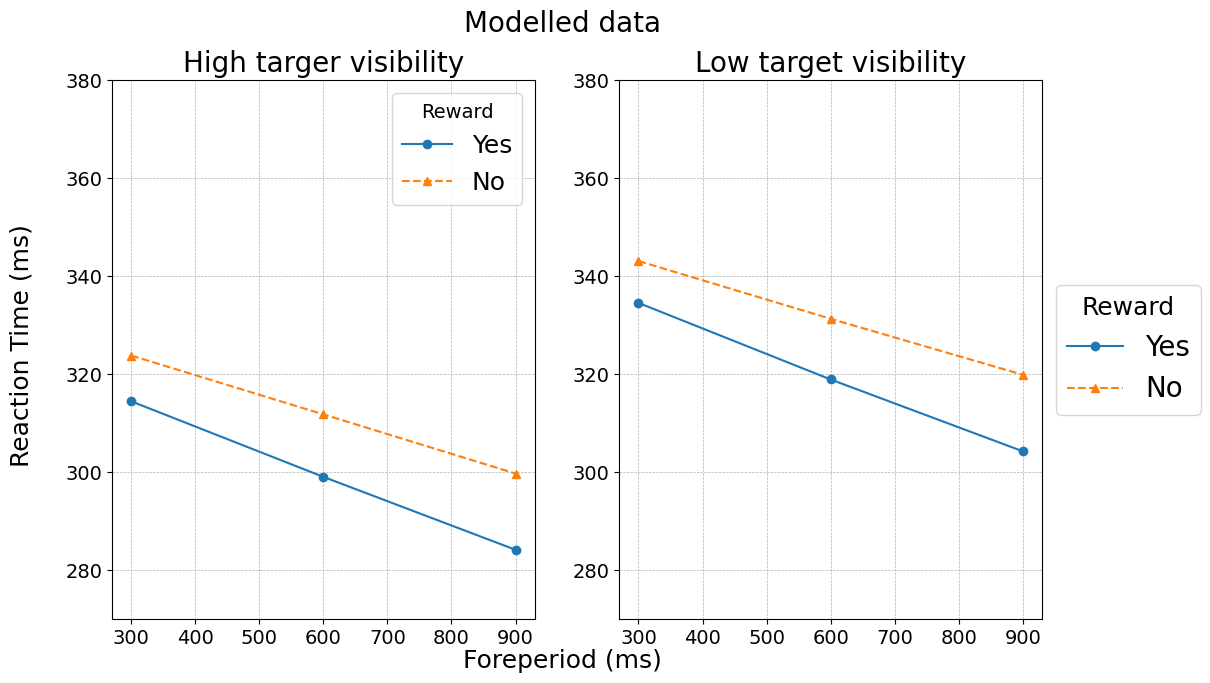

In [7]:
plt.rcParams.update({'font.size': 14})

data_avg = pd.DataFrame(columns = ["visibility", "reward","RT_avg", "FP"])

reward = [True, False]
reward_names = ["Yes", "No"]
visibility = [True, False]
visibility_names =["High targer visibility", "Low target visibility"]
FP_options =  [ 0.3, 0.6, 0.9]

markers = ['o', '^']
lines = ['-', '--']


for v in visibility:
    data_v = results_all_subjects[results_all_subjects['visibility'] == v]
    for r in reward:
        data_v_r = data_v[data_v['reward'] == r]
        for fp in FP_options:
            data_v_r_fp = data_v_r[data_v_r['FP'] == fp]
            rt_avg = np.mean(data_v_r_fp['RT'])
            data_avg.loc[len(data_avg)] = [v, r, rt_avg, fp]

data_avg.to_csv('Average_modelled_data.csv')

## Plotting the data
fig, ax = plt.subplots(1, 2, figsize=(12,7)) 
fig.suptitle('Modelled data', fontsize = 20)
fig.text(0.5, 0.04, 'Foreperiod (ms)', ha='center', fontsize = 18)
fig.text(0.04, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 18)
for vis in range(len(visibility)):
    dv = data_avg[data_avg['visibility'] == visibility[vis]]
    for rew in range(len(reward)):
        dvr = dv[dv['reward'] == reward[rew]]
        ax[vis].plot(dvr["FP"]*1000, dvr["RT_avg"]*1000, marker = markers[rew], linestyle = lines[rew], label = reward_names[rew])

    ax[vis].set_ylim([270, 380])

    ax[vis].set_title(visibility_names[vis], fontsize = 20)
    ax[vis].legend(title = 'Reward', fontsize = 18)
    ax[vis].grid(linestyle='--', linewidth=.5)

    if  vis == 1 :
        ax[vis].legend(title = 'Reward',  title_fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)

plt.show()


## Reaction time vs Foreperiod by visibility, reward and previous foreperiod FP1

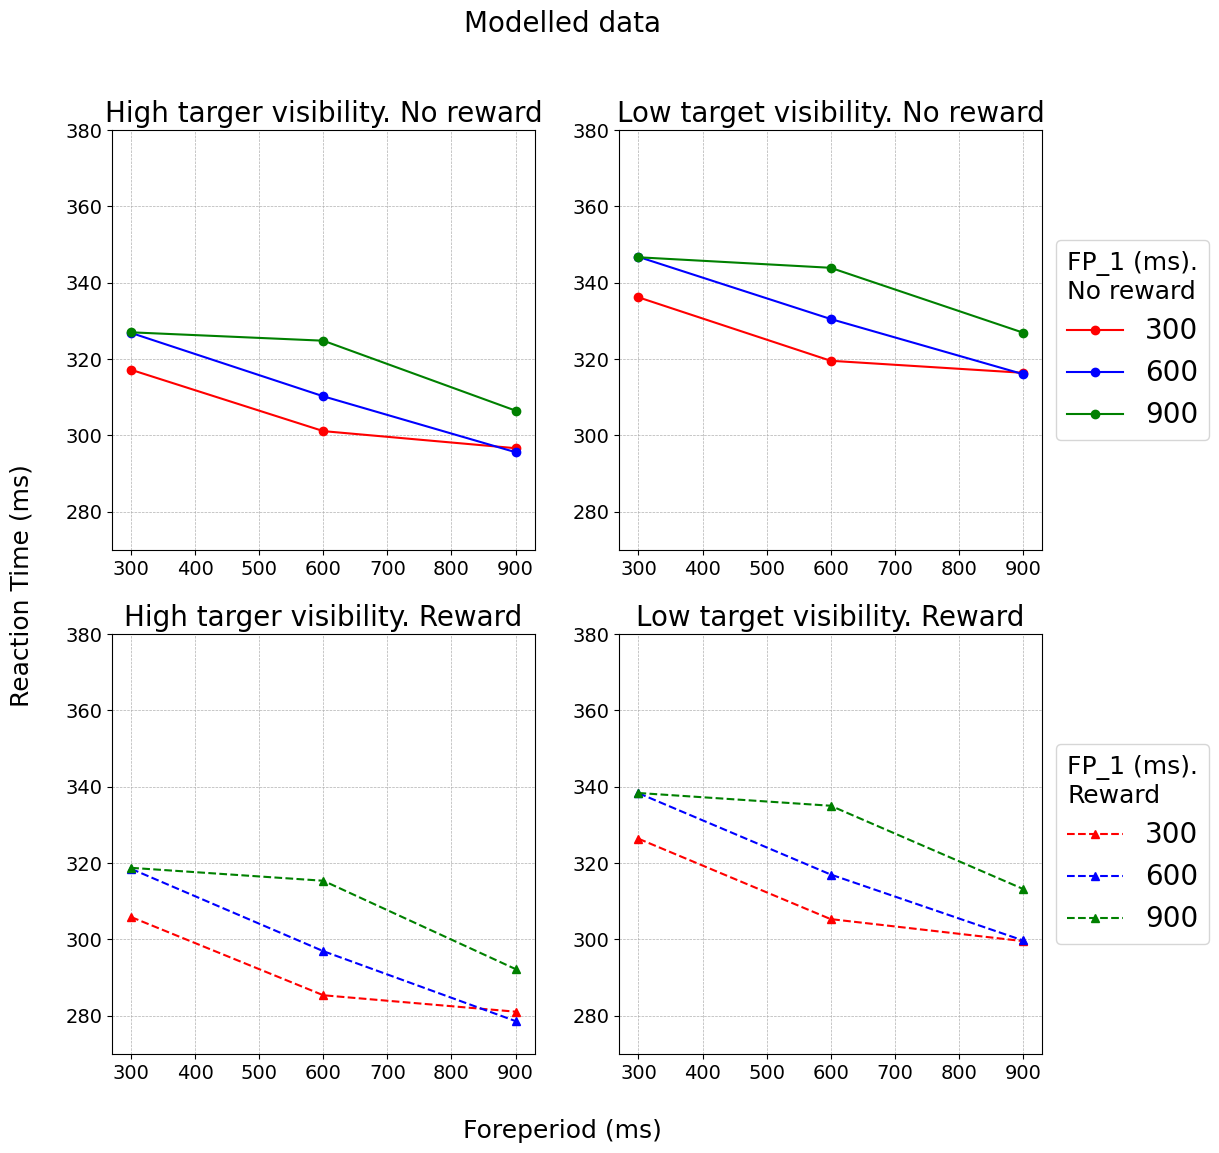

In [8]:

## Group by visibility and reaward

data_avg = pd.DataFrame(columns = ["visibility", "reward","RT_avg", "FP1", "FP"])

reward = [False, True]
reward_names = ["No reward", "Reward"]
visibility = [True, False]
visibility_names =["High targer visibility", "Low target visibility"]
FP_options =  [ 0.3, 0.6, 0.9]

markers = ['o', '^']
lines = ['-', '--']
colors = ['r', 'b', 'g']


for v in visibility:
    data_v = results_all_subjects[results_all_subjects['visibility'] == v]
    for r in reward:
        data_v_r = data_v[data_v['reward'] == r]
        for fp1 in FP_options:
            data_v_r_fp1 = data_v_r[data_v_r['FP1'] == fp1]
            for fp in FP_options:
                data_v_r_fp1_fp = data_v_r_fp1[data_v_r_fp1['FP'] == fp]
                rt_avg = np.mean(data_v_r_fp1_fp['RT'])
                data_avg.loc[len(data_avg)] = [v, r, rt_avg, fp1, fp]

data_avg.to_csv('Average_modelled_data_fp1.csv')

## Plotting the data
fig, ax = plt.subplots(2, 2, figsize=(12,12)) 
fig.suptitle('Modelled data', fontsize = 20)
fig.text(0.5, 0.04, 'Foreperiod (ms)', ha='center', fontsize = 18)
fig.text(0.04, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 18)
for rew in range(len(reward)):
    dr = data_avg[data_avg['reward'] == reward[rew]]
    for vis in range(len(visibility)):
        drv = dr[dr['visibility'] == visibility[vis]]
        for fp1 in range(len(FP_options)):
            drvf1 = drv[drv["FP1"] == FP_options[fp1]]
            ax[rew, vis].plot(drvf1["FP"]*1000, drvf1["RT_avg"]*1000, marker = markers[rew], linestyle = lines[rew], color = colors[fp1], label = int(FP_options[fp1]*1000))

        ax[rew, vis].set_ylim([270, 380])

        ax[rew, vis].set_title(visibility_names[vis]+". " + reward_names[rew], fontsize = 20)
        ax[rew, vis].grid(linestyle='--', linewidth=.5)

        
        if  vis == 1 :
            ax[rew, vis].legend(title = 'FP_1 (ms).\n' + reward_names[rew],  title_fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =20)
plt.show()


## Reaction time vs Foreperiod by reward and different number of previous foreperiods FPk k=1, 2, 3, 4, 5

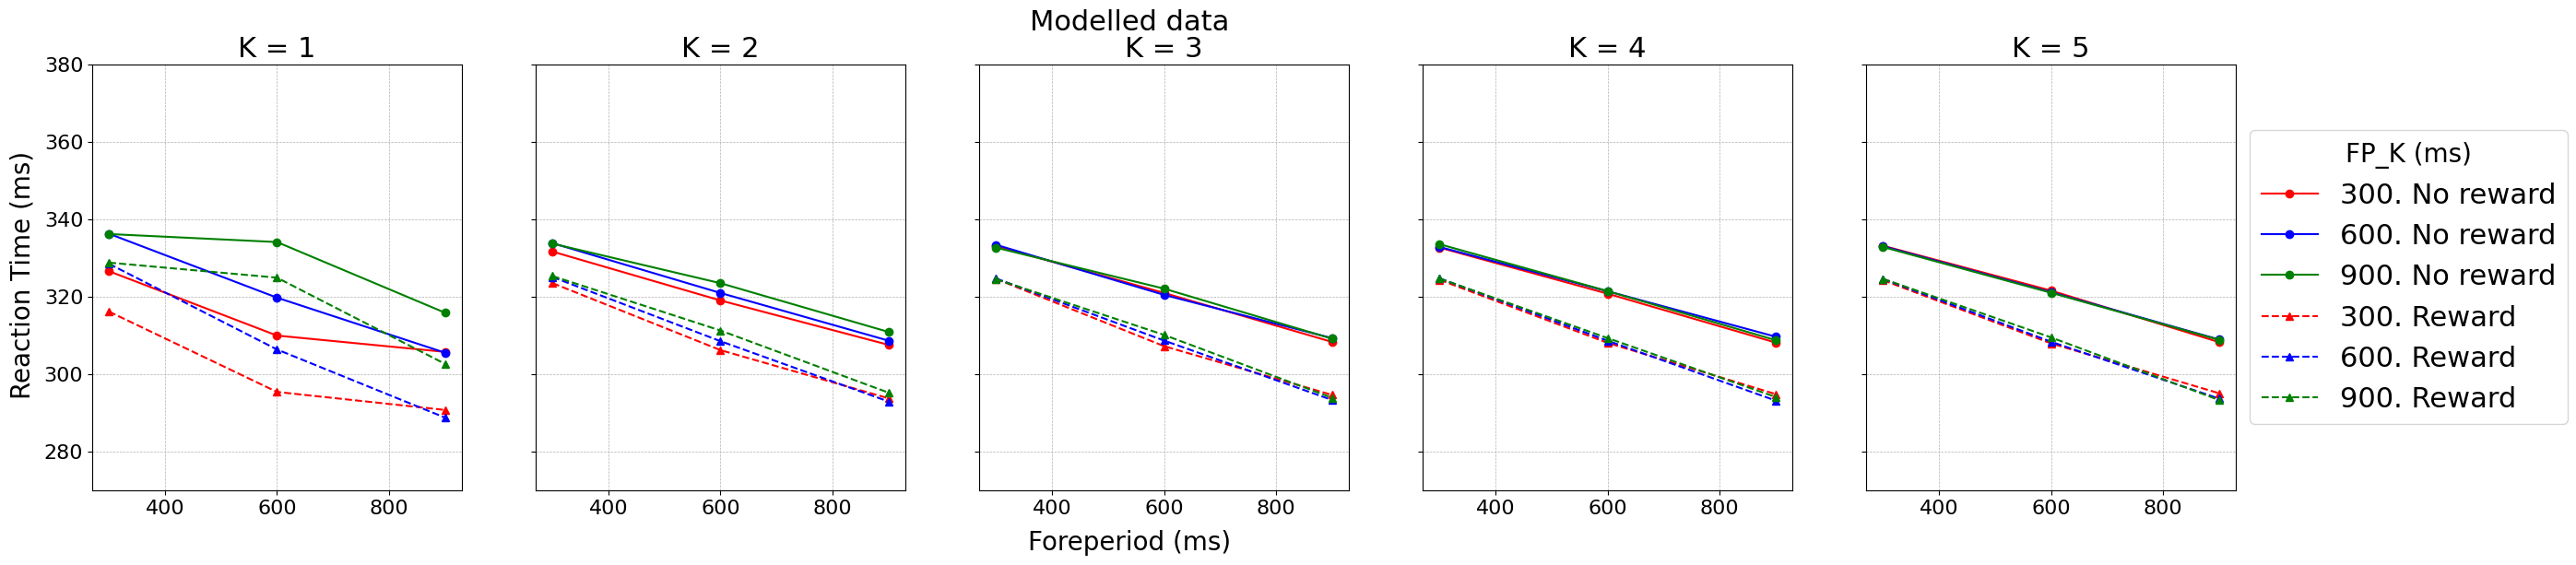

In [9]:

## Group by visibility and reaward
#
plt.rcParams.update({'font.size': 16})
       
data_avg = pd.DataFrame(columns = ["reward","RT_avg", "FPK", "FP", "k"])

reward = [False, True]
reward_names = ["No reward", "Reward"]
FP_options =  [ 0.3, 0.6, 0.9]
markers = ['o', '^']
lines = ['-', '--']
colors = ['r', 'b', 'g']

for k in range(5):
    for r in reward:
        data_r = results_all_subjects[results_all_subjects['reward'] == r]
        for fpk in range(len(FP_options)):
            fpk_name = 'FP'+ str(k+1)
            data_r_fpk = data_r[data_r[fpk_name] == FP_options[fpk]]
            for fp in FP_options:
                data_r_fpk_fp = data_r_fpk[data_r_fpk['FP'] == fp]
                rt_avg = np.mean(data_r_fpk_fp['RT'])
                data_avg.loc[len(data_avg)] = [r, rt_avg, FP_options[fpk], fp, k+1]
                
## Plotting the data
fig, ax = plt.subplots(1, 5, figsize=(30,6), sharex=True, sharey=True,) 
fig.suptitle('Modelled data', fontsize = 22)


fig.text(0.5, 0.001, 'Foreperiod (ms)', ha='center', fontsize = 20)
fig.text(0.095, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 20)

for k in range(5):
    dk = data_avg[data_avg['k'] == k+1]
    for rew in range(len(reward)):
        drv = dk[dk['reward'] == reward[rew]]
        for fpk in range(len(FP_options)):
            drvf1 = drv[drv["FPK"] == FP_options[fpk]]
            ax[k].plot(drvf1["FP"]*1000, drvf1["RT_avg"]*1000, marker = markers[rew], linestyle = lines[rew], color = colors[fpk] , label =str(int(FP_options[fpk]*1000))+". " + reward_names[rew] )
        

    ax[k].set_ylim([270, 380])

    ax[k].set_title("K = "+ str(k+1),  fontsize = 22)
    ax[k].grid(linestyle='--', linewidth=.5)
    if k ==4:
        ax[k].legend(title = 'FP_K (ms)',  title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 22)

plt.show()



## PLOTTING THE REAL DATA

In [10]:
real_data = pd.read_csv('assignment_bundle/real_data.csv')
real_data = real_data[real_data["outlier"] == "no"]

real_data_summ= real_data[["reward","target_visibility","fp","fp_1","fp_2","fp_3","fp_4","fp_5","RT"]]

FileNotFoundError: [Errno 2] No such file or directory: 'assignment_bundle/real_data.csv'

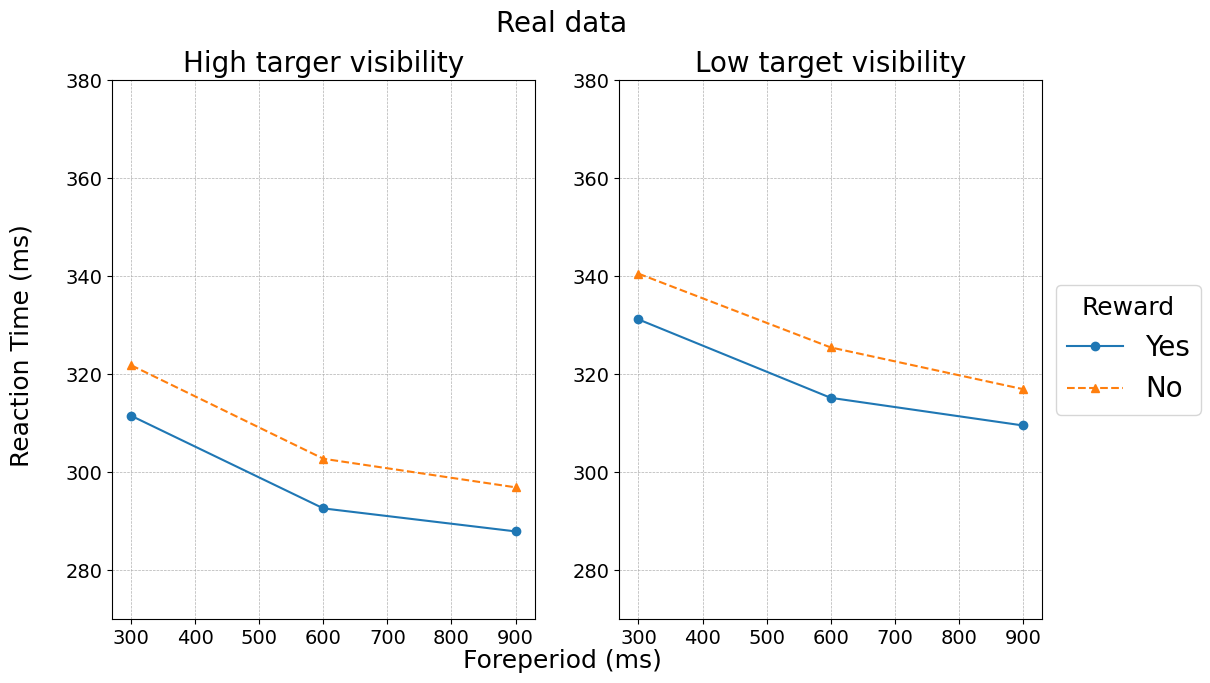

In [ ]:
plt.rcParams.update({'font.size': 14})

data_avg = pd.DataFrame(columns = ["visibility", "reward","RT_avg", "FP"])


reward = ["yes", "no"]
reward_names = ["Yes", "No"]

visibility = ["hi", "lo"]
visibility_names =["High targer visibility", "Low target visibility"]
FP_options =  [ 0.3, 0.6, 0.9]

markers = ['o', '^']
lines = ['-', '--']


for v in visibility:
    data_v = real_data_summ[real_data_summ['target_visibility'] == v]
    for r in reward:
        data_v_r = data_v[data_v['reward'] == r]
        for fp in FP_options:
            data_v_r_fp = data_v_r[data_v_r["fp"] == fp]
            rt_avg = np.mean(data_v_r_fp['RT'])
            data_avg.loc[len(data_avg)] = [v, r, rt_avg, fp]

## Plotting the data
fig, ax = plt.subplots(1, 2, figsize=(12,7)) 
fig.suptitle('Real data', fontsize = 20)
fig.text(0.5, 0.04, 'Foreperiod (ms)', ha='center', fontsize = 18)
fig.text(0.04, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 18)
for vis in range(len(visibility)):
    dv = data_avg[data_avg['visibility'] == visibility[vis]]
    for rew in range(len(reward)):
        dvr = dv[dv['reward'] == reward[rew]]
        ax[vis].plot(dvr["FP"]*1000, dvr["RT_avg"], marker = markers[rew], linestyle = lines[rew], label = reward_names[rew])

    ax[vis].set_ylim([270, 380])

    ax[vis].set_title(visibility_names[vis], fontsize = 20)
    ax[vis].grid(linestyle='--', linewidth=.5)

    if  vis == 1 :
        ax[vis].legend(title = 'Reward',  title_fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
plt.show()


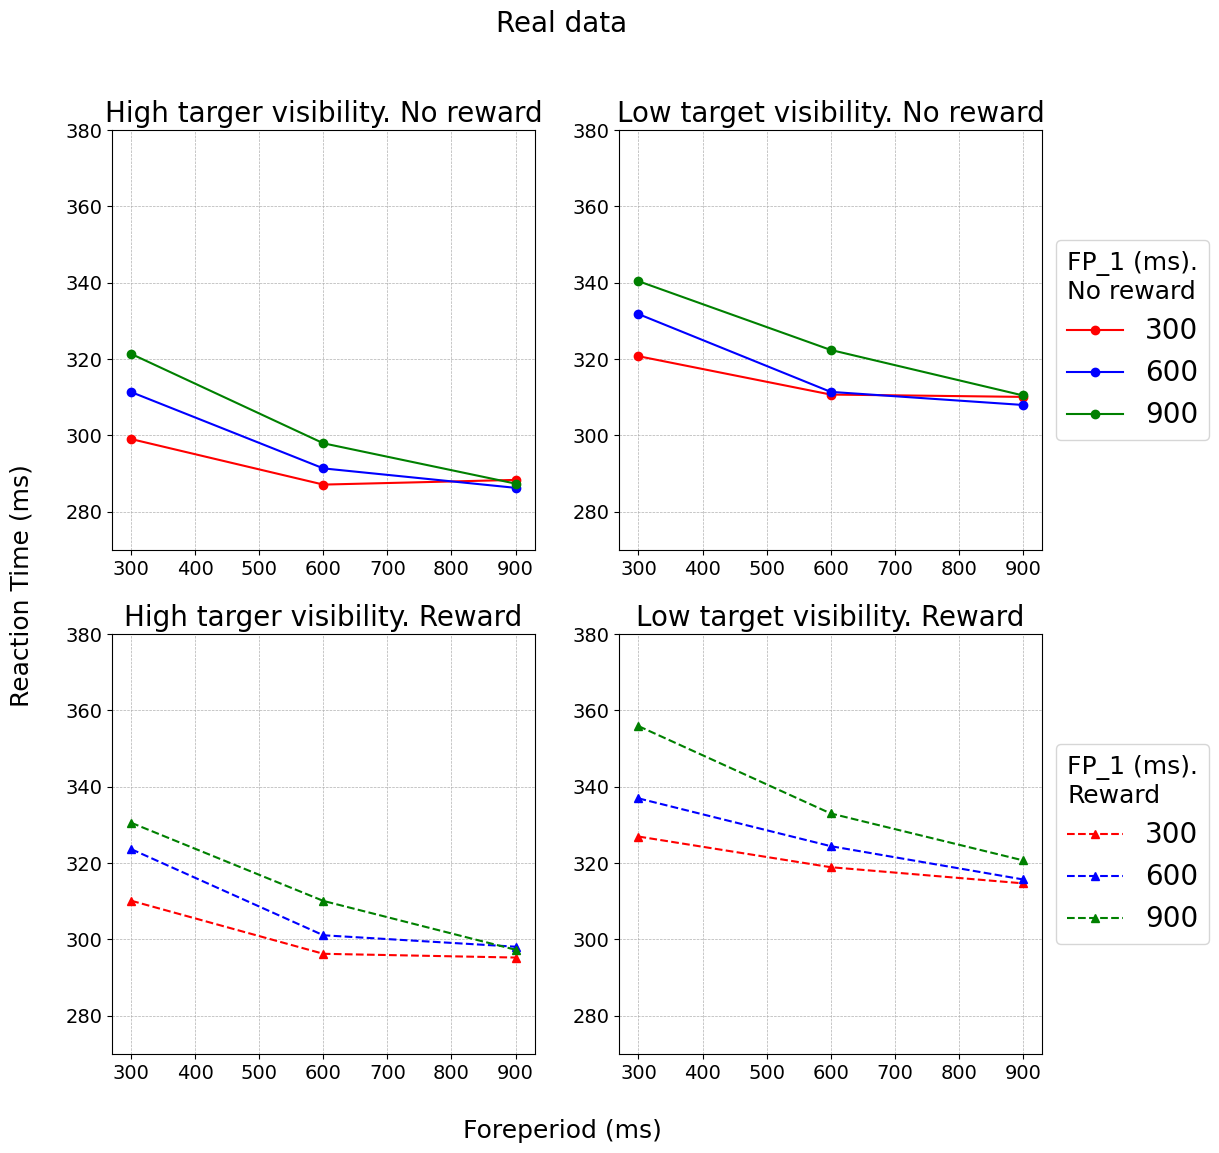

In [ ]:


## Group by visibility and reaward
#        
data_avg = pd.DataFrame(columns = ["visibility", "reward","RT_avg", "FP1", "FP"])

reward = ["yes", "no"]
visibility = ["hi", "lo"]
reward_names = ["No reward", "Reward"]
visibility_names =["High targer visibility", "Low target visibility"]
FP_options =  [ 0.3, 0.6, 0.9]

markers = ['o', '^']
lines = ['-', '--']
colors = ['r', 'b', 'g']


for v in visibility:
    data_v = real_data_summ[real_data_summ['target_visibility'] == v]
    for r in reward:
        data_v_r = data_v[data_v['reward'] == r]
        for fp1 in FP_options:
            data_v_r_fp1 = data_v_r[data_v_r['fp_1'] == fp1]
            for fp in FP_options:
                data_v_r_fp1_fp = data_v_r_fp1[data_v_r_fp1['fp'] == fp]
                rt_avg = np.mean(data_v_r_fp1_fp['RT'])
                data_avg.loc[len(data_avg)] = [v, r, rt_avg, fp1, fp]

data_avg.to_csv('Average_modelled_data_fp1.csv')

## Plotting the data
fig, ax = plt.subplots(2, 2, figsize=(12,12)) 
fig.suptitle('Real data', fontsize = 20)
fig.text(0.5, 0.04, 'Foreperiod (ms)', ha='center', fontsize = 18)
fig.text(0.04, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 18)

for rew in range(len(reward)):
    dr = data_avg[data_avg['reward'] == reward[rew]]
    for vis in range(len(visibility)):
        drv = dr[dr['visibility'] == visibility[vis]]
        for fp1 in range(len(FP_options)):
            drvf1 = drv[drv["FP1"] == FP_options[fp1]]
            ax[rew, vis].plot(drvf1["FP"]*1000, drvf1["RT_avg"], marker = markers[rew], linestyle = lines[rew], color = colors[fp1], label = int(FP_options[fp1]*1000))

        ax[rew, vis].set_ylim([270, 380])

        ax[rew, vis].set_title(visibility_names[vis]+". " + reward_names[rew], fontsize = 20)
        ax[rew, vis].grid(linestyle='--', linewidth=.5)

        if  vis == 1 :
            ax[rew, vis].legend(title = 'FP_1 (ms).\n' + reward_names[rew],  title_fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)

plt.show()


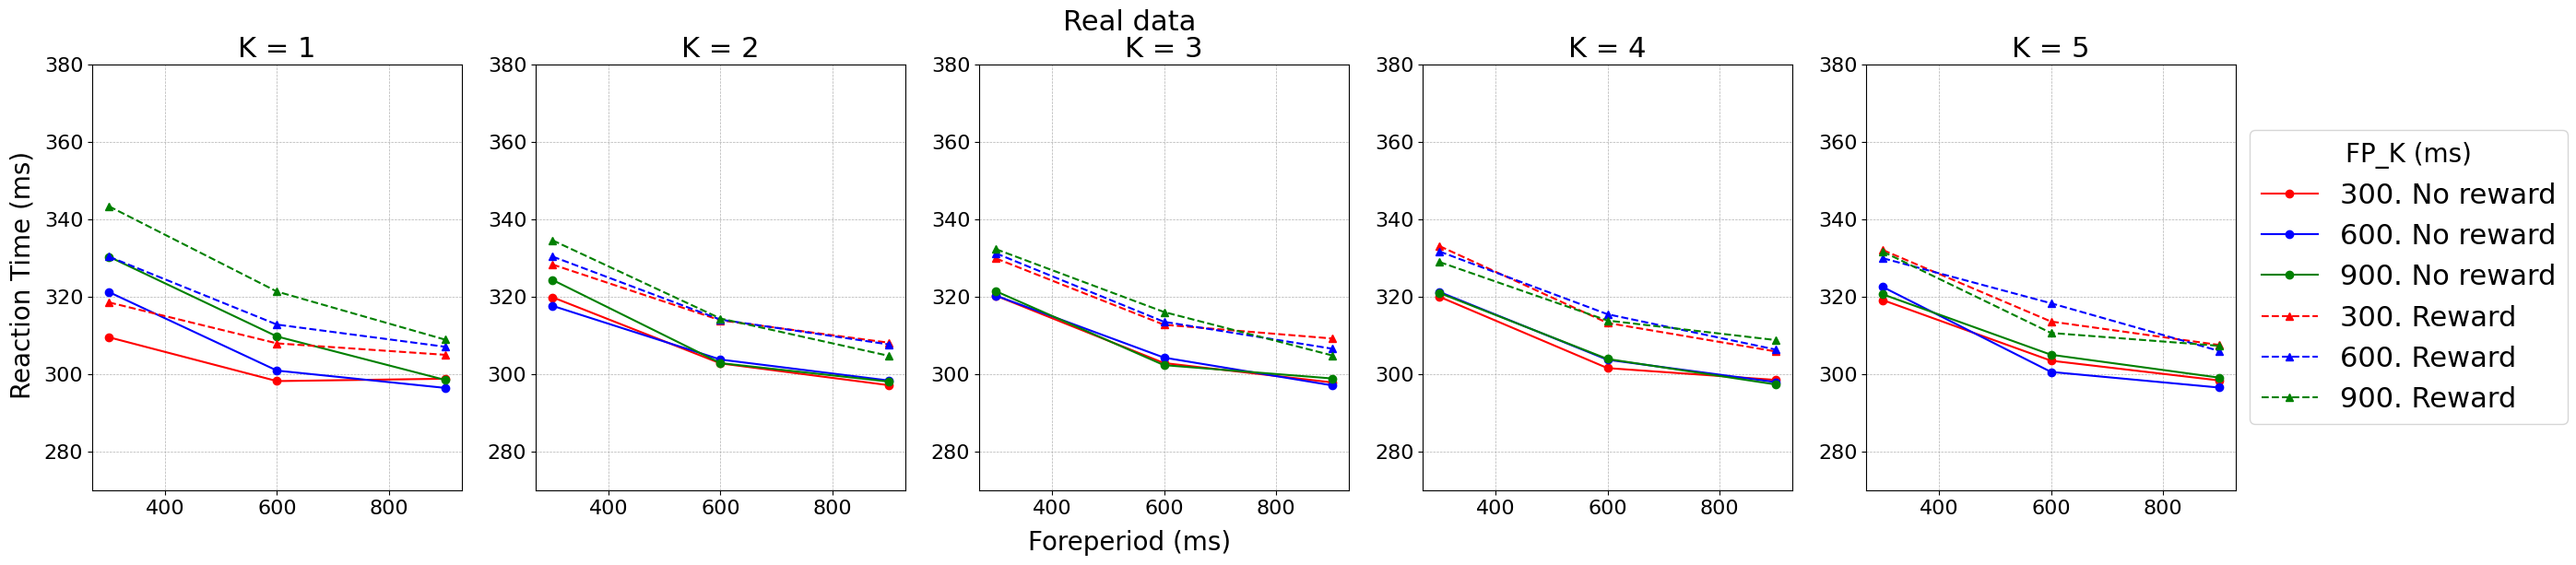

In [ ]:

## Group by visibility and reaward
#        
plt.rcParams.update({'font.size': 16})

data_avg = pd.DataFrame(columns = ["reward","RT_avg", "FPK", "FP", "k"])

reward = ["yes", "no"]
FP_options =  [ 0.3, 0.6, 0.9]

markers = ['o', '^']
lines = ['-', '--']
colors = ['r', 'b', 'g']
## Plotting the data
fig, ax = plt.subplots(1, 5, figsize=(30,6)) 
fig.suptitle('Real data', fontsize = 22)

fig.text(0.5, 0.001, 'Foreperiod (ms)', ha='center', fontsize = 20)
fig.text(0.095, 0.5, 'Reaction Time (ms)', va='center', rotation='vertical', fontsize = 20)

for k in range(5):
    for r in reward:
        data_r = real_data_summ[real_data_summ['reward'] == r]
        for fpk in range(len(FP_options)):
            fpk_name = 'fp_'+ str(k+1)
            data_r_fpk = data_r[data_r[fpk_name] == FP_options[fpk]]
            for fp in FP_options:
                data_r_fpk_fp = data_r_fpk[data_r_fpk['fp'] == fp]
                rt_avg = np.mean(data_r_fpk_fp['RT'])
                data_avg.loc[len(data_avg)] = [r, rt_avg, FP_options[fpk], fp, k+1]

for k in range(5):
    dk = data_avg[data_avg['k'] == k+1]
    for rew in range(len(reward)):
        drv = dk[dk['reward'] == reward[rew]]
        for fpk in range(len(FP_options)):
            drvf1 = drv[drv["FPK"] == FP_options[fpk]]
            ax[k].plot(drvf1["FP"]*1000, drvf1["RT_avg"], marker = markers[rew], linestyle = lines[rew], color = colors[fpk] , label =str(int(FP_options[fpk]*1000))+". " + reward_names[rew] )
        
  
    ax[k].set_ylim([270, 380])

    ax[k].set_title("K = "+ str(k+1),  fontsize = 22)
    ax[k].grid(linestyle='--', linewidth=.5)
    if k ==4:
        ax[k].legend(title = 'FP_K (ms)',  title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 22)


plt.show()

